# Calculate & Alfven wave instability threshold

In [1]:
import numpy as np
import scipy.optimize
import scipy.interpolate
from py_vlasov.util import kzkp
# from py_vlasov.util import zp, kzkp, list_to_complex, real_imag
# from py_vlasov.wrapper import oblique_wrapper, disp_det, input_gen
# from py_vlasov.transport_ratios import transport_ratios
# from py_vlasov.follow_parameter import generate_steps, solve_disp
from KSpaceSearch import KThetaScan
import matplotlib.pyplot as plt
import matplotlib as mpl
from math import ceil
import os
import pandas as pd

mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.minor.size'] = 3.5
mpl.rcParams['xtick.major.width'] = 1.1
mpl.rcParams['ytick.major.width'] = 1.1
mpl.rcParams['xtick.minor.width'] = .8
mpl.rcParams['ytick.minor.width'] = .8
mpl.rcParams['legend.fontsize'] = 14
#xtick.major.size     : 3.5      # major tick size in points
#xtick.minor.size     : 2      # minor tick size in points
#xtick.major.width    : 0.8    # major tick width in points
#xtick.minor.width    : 0.6    # minor tick width in points
%matplotlib inline

## Base parameters

In [2]:
# aol = np.sqrt(2.65e-8)
aol = np.sqrt(1e-8)
print('aol = ', aol)
tc_tp = 2
th_tc = 6
nc_np = 0.95
nh_np = 1 - nc_np
# vc_va = 2.42
vc_va = 5
vh_va = -vc_va * nc_np / nh_np
print('vh_va = {0:.3g}'.format(vh_va))

# betap = 0.25
betap = .5
theta = 80


t_list=[1., tc_tp, th_tc * tc_tp]
a_list=[1., 1., 1.]
n_list=[1., nc_np, nh_np] 
q_list=[1.,-1., -1.]
m_list=[1., 1./1836., 1./1836]
v_list=[0., vc_va, vh_va]
n = 6
method = 'pade'

k = 0.2

target_k = 2

kz, kp = kzkp(k, theta)

param = [kz, kp, betap, t_list, a_list, n_list, q_list,
         m_list, v_list, n, method, aol]

aol =  0.0001
vh_va = -95


In [3]:
def genParam(betap, vcva, param):
    newParam = param.copy()
    newParam[2] = betap
    n_list = param[5]
    vhva = - vcva * n_list[1] / n_list[2]
    newParam[8] = [0, vcva, vhva]
    return newParam

In [242]:
# Data for this iteration

betap = .8
vcva = 4.95
new_param = genParam(betap, vcva, param)

# data storage

In [243]:
result_db_file = 'data/alfven_instability.csv'
column_list = ['betap', 'vcva', 'tctp', 'thtc', 'vac', 
               'max_growth_rate', 'kz_peak', 'kp_peak', 'theta_peak']
if os.path.exists(result_db_file):
    df = pd.read_csv(result_db_file)
else:
    df = pd.DataFrame(columns= column_list)

In [244]:
# df = df.iloc[1:]
df

,betap,vcva,tctp,thtc,vac,max_growth_rate,kz_peak,kp_peak,theta_peak
0,0.1,1.0,2,6,0.0001,0.000031,0.157,0.270,59.9
1,0.1,1.2,2,6,0.0001,0.000528,0.163,0.393,67.5
2,0.1,1.3,2,6,0.0001,0.000906,0.161,0.445,70.1
3,0.1,1.4,2,6,0.0001,0.001390,0.164,0.481,71.1
4,0.1,1.8,2,6,0.0001,0.004380,0.153,0.745,78.4
5,0.2,1.8,2,6,0.0001,0.000849,0.174,0.712,76.3
6,0.2,1.9,2,6,0.0001,0.001440,0.174,0.773,77.3
7,0.2,2.0,2,6,0.0001,0.002080,0.174,0.841,78.3
8,0.3,2.4,2,6,0.0001,0.000683,0.182,1.060,80.2
9,0.3,2.5,2,6,0.0001,0.001380,0.180,1.090,80.6


In [245]:
alfven_stop_condition = lambda wrel: (wrel.real > 1) or (wrel.real < 0) or (wrel.imag < -.5)
ktscan = KThetaScan(new_param, 
                    lin_incrmt=.05, 
                    incrmt_method='linear', 
                    stop_condition=alfven_stop_condition, 
                    diagnostic_dir = 'alfven_instability_diagnostics/', 
                    savefig = True)

No user provided wave mode guess function. Use default Alfven guess.


In [246]:
theta_min = 83
theta_max = 88
n_theta = int(np.ceil(theta_max - theta_min)+1) * 2
theta_arr = np.linspace(theta_min, theta_max, n_theta)

In [247]:
k_min = 0.4
k_max = 3.5

kz_2d, kp_2d, k_2d, wrel_2d = ktscan.fullScan(theta_arr, k_min, k_max)

betap=0.8_vcva=4.95_tctp=2_thtc=6_vac=0.0001


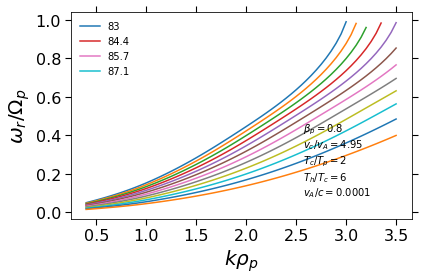

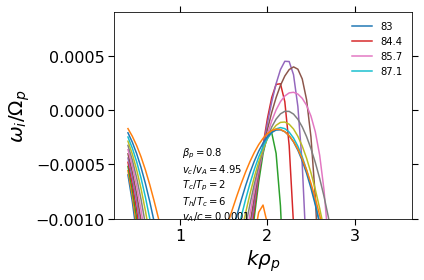

In [248]:
ktscan.makeDiagnostics1D(theta_arr, k_2d, wrel_2d)

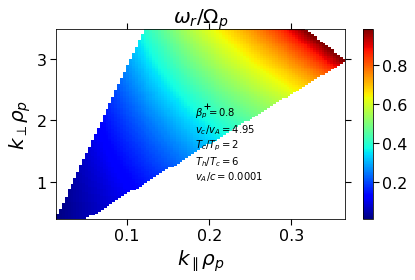

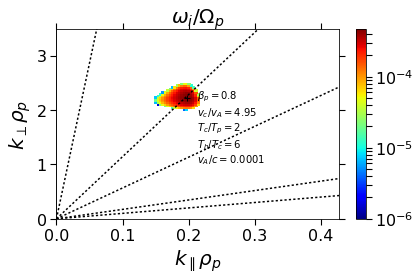

In [249]:
ktscan.makeDiagnostics2D(theta_arr, kz_2d, kp_2d, wrel_2d)

In [250]:
# save data to file

data_dict = {'betap': betap, 'vcva': vcva, 'tctp': tc_tp, 'thtc': th_tc, 'vac': aol, 
             'max_growth_rate': ktscan.maxGrowthRate, 
             'kz_peak': ktscan.maxGrowthK[0], 
             'kp_peak': ktscan.maxGrowthK[1], 
             'theta_peak': ktscan.maxGrowthTheta}
new_row = pd.DataFrame(data=data_dict, columns=column_list, index=[0])
df = df.append(new_row)

In [251]:
ktscan.maxGrowthRate

0.0004737873367651476

In [252]:
# df = df.iloc[:-1]
df = df.sort_values(['betap', 'vcva'], ascending=[True, True])
df

,betap,vcva,tctp,thtc,vac,max_growth_rate,kz_peak,kp_peak,theta_peak
0,0.1,1.00,2,6,0.0001,0.000031,0.157000,0.270000,59.900000
1,0.1,1.20,2,6,0.0001,0.000528,0.163000,0.393000,67.500000
2,0.1,1.30,2,6,0.0001,0.000906,0.161000,0.445000,70.100000
3,0.1,1.40,2,6,0.0001,0.001390,0.164000,0.481000,71.100000
4,0.1,1.80,2,6,0.0001,0.004380,0.153000,0.745000,78.400000
5,0.2,1.80,2,6,0.0001,0.000849,0.174000,0.712000,76.300000
6,0.2,1.90,2,6,0.0001,0.001440,0.174000,0.773000,77.300000
7,0.2,2.00,2,6,0.0001,0.002080,0.174000,0.841000,78.300000
8,0.3,2.40,2,6,0.0001,0.000683,0.182000,1.060000,80.200000
9,0.3,2.50,2,6,0.0001,0.001380,0.180000,1.090000,80.600000


In [253]:
df.to_csv(result_db_file, float_format='%.3g', index=False)

In [257]:
# !ls alfven_instability_diagnostics

In [261]:
!du -sh data/alfven_instability.csv

4.0K	data/alfven_instability.csv


In [260]:
result_db_file

'data/alfven_instability.csv'

In [262]:
!pwd

/Users/Tong/Google_Drive/research/packages/vlasov_solver/tests
